# Twitter US Airlines

Data visualization for twitter airlines data for sentiment analysis

In [1]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
matplotlib.rcParams['figure.dpi'] = 200

try:
    import seaborn as sns
except:
    print('Seaborn must be installed to continue (pip install seaborn).\nIt provides an enhanced plotting experience', file=sys.stderr)
    if input('Do you want me to do it for you? y/n') == 'y':
        !pip install seaborn
    
    import seaborn as sns

## Prepare data

Read csv and enforce datetime to the tweet created column

In [2]:
# Read CSV file
df = pd.read_csv('tweets_public.csv', index_col='tweet_id')
# Force datatime on the `tweet_created` column
df.tweet_created = pd.to_datetime(df.tweet_created)

# How many tweets do we have?
print("Number of tweets:", df.shape[0])

# Show first rows on dataframe
df.head()

Number of tweets: 8784


,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
569237160886276096,negative,1.0000,Can't Tell,0.6543,Delta,NaN,venkatesh_cr,NaN,0,@JetBlue I've been in pricing for 8 years to k...,NaN,2015-02-21 20:48:09,Austin Texas,Central Time (US & Canada)
569267194028298241,negative,1.0000,Customer Service Issue,1.0000,Southwest,NaN,ChristineFlores,NaN,0,"@SouthwestAir AH - did DM, no reply. On hold n...",NaN,2015-02-21 22:47:30,NaN,Central Time (US & Canada)
569506670189137920,negative,0.6473,Lost Luggage,0.6473,United,NaN,szymanski_t,NaN,0,@united if you lost my belongings then BE HONEST!,NaN,2015-02-22 14:39:05,NaN,Eastern Time (US & Canada)
570293957739081728,negative,1.0000,Customer Service Issue,1.0000,United,NaN,nate2482,NaN,0,@United the internet is a great thing. I am e...,NaN,2015-02-24 18:47:29,"Parkersburg, WV",Eastern Time (US & Canada)
570212129313316864,neutral,1.0000,NaN,NaN,Delta,NaN,elias_rubin,NaN,0,@JetBlue I believe that the website said I cou...,NaN,2015-02-24 13:22:20,"New York, NY",Pacific Time (US & Canada)


Let's see some randomly drawn examples of tweets

In [3]:
tweet_1 = df.sample(n=1, random_state=0).squeeze()
tweet_2 = df.sample(n=1, random_state=2).squeeze()
tweet_3 = df.sample(n=1, random_state=5).squeeze()
# Note, squeeze converts a DataFrame with 1 entry (n=1)
# to a Series
tweet_1

airline_sentiment                                    neutral
airline_sentiment_confidence                          0.6501
negativereason                                           NaN
negativereason_confidence                                  0
airline                                                Delta
airline_sentiment_gold                                   NaN
name                                             TaocHoddock
negativereason_gold                                      NaN
retweet_count                                              0
text                            .@JetBlue Delete this tweet.
tweet_coord                                              NaN
tweet_created                            2015-02-23 19:50:13
tweet_location                                       Denmark
user_timezone                                      Amsterdam
Name: 569947356428419073, dtype: object

In [4]:
# Specifically query some of its attributes
print('TWEET SAMPLE 1')
print(tweet_1['text'])
print(tweet_1.airline_sentiment)
print(tweet_1.tweet_created)
print('')

print('TWEET SAMPLE 2')
print(tweet_2['text'])
print(tweet_2.airline_sentiment)
print(tweet_2.tweet_created)
print('')

TWEET SAMPLE 1
.@JetBlue Delete this tweet.
neutral
2015-02-23 19:50:13

TWEET SAMPLE 2
@SouthwestAir loving the boarding to go to Chicago #KeepItMovin'
positive
2015-02-21 12:14:58



Manually select a tweet and view it

In [5]:
# By using its index id
tweet_m1 = df.loc[569237160886276096]

# By using its position in the dataframe
tweet_m2 = df.iloc[0]

In [6]:
print('TWEET BY INDEX ID')
print(tweet_m1['text'])
print(tweet_m1.airline_sentiment)
print(tweet_m1.tweet_created)
print('')

print('TWEET BY POSITION')
print(tweet_m2['text'])
print(tweet_m2.airline_sentiment)
print(tweet_m2.tweet_created)
print('')

TWEET BY INDEX ID
@JetBlue I've been in pricing for 8 years to know that 70 bucks a seat is criminal. 20-30 I understand. #pricing #flying #jetblue #pricewise
negative
2015-02-21 20:48:09

TWEET BY POSITION
@JetBlue I've been in pricing for 8 years to know that 70 bucks a seat is criminal. 20-30 I understand. #pricing #flying #jetblue #pricewise
negative
2015-02-21 20:48:09



## Sentiments

The dataset is composed by 3 types of labels, namely `positive`, `neutral` and `negative`.  It can be easily checked by `df['airline_sentiment'].unique()`.

Also, and important point to check whether the dataset is balanced, that is if all classes/label have the same amount of tweets

In [7]:
df['airline_sentiment'].unique()

array(['negative', 'neutral', 'positive'], dtype=object)

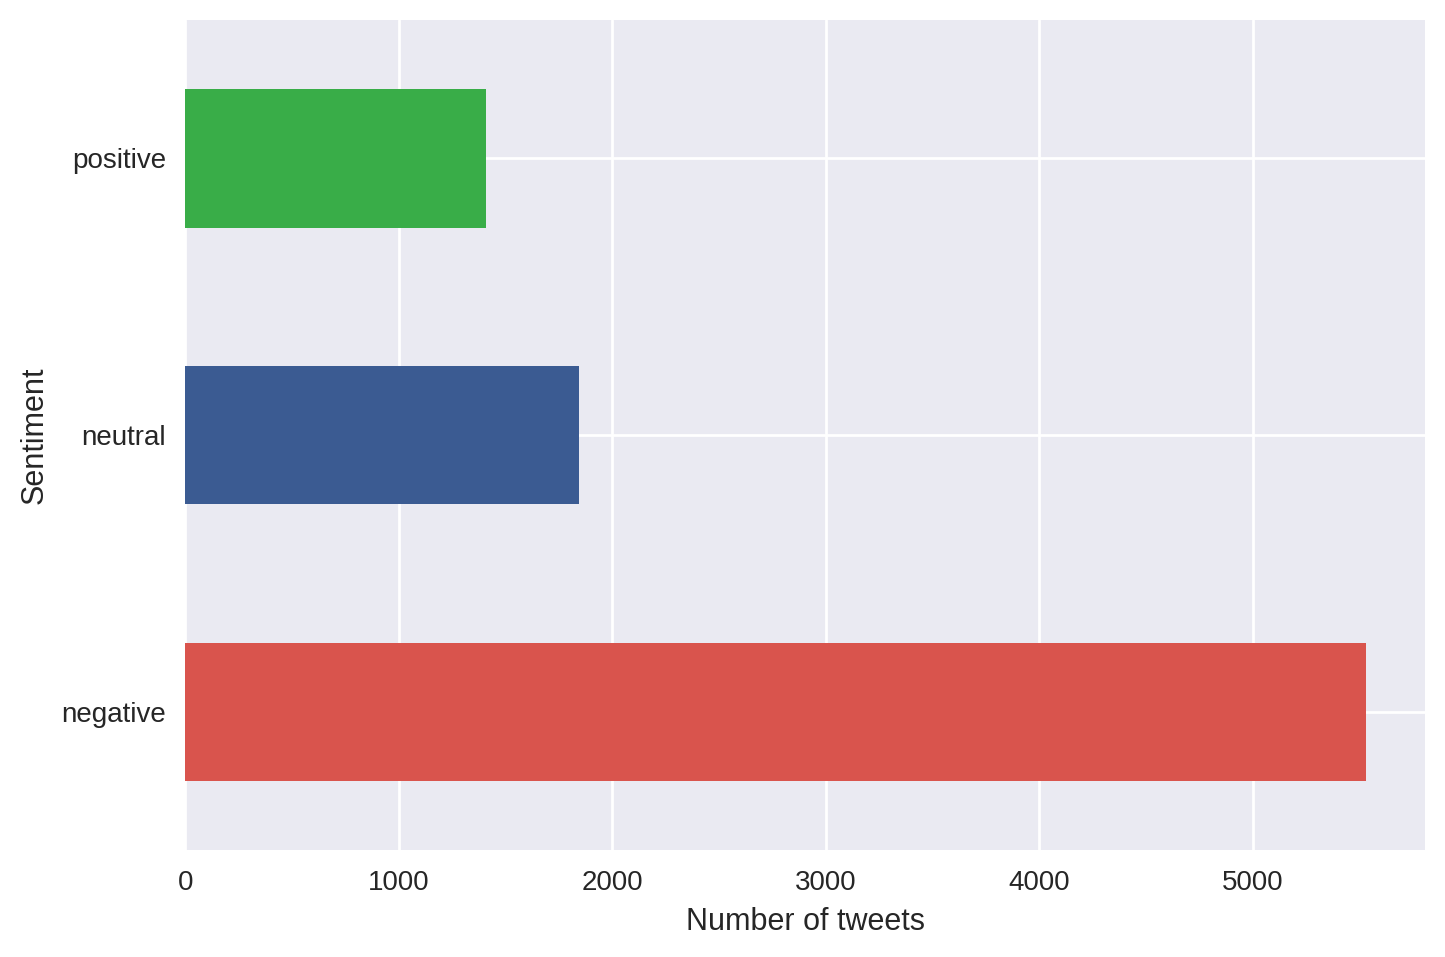

In [8]:
# Group by sentiments, so that we have an structure like
#  positive -> [tweet_1, ..., tweet_n]
#  neutral  -> [tweet_1, ..., tweet_r]
#  negative -> [tweet_1, ..., tweet_s]
sentiments = df.groupby('airline_sentiment').size()

# Plot horizaontally with bars
ax = sentiments.plot.barh(color=[sns.xkcd_rgb["pale red"],
                                 sns.xkcd_rgb["denim blue"], 
                                 sns.xkcd_rgb["medium green"]])
# Rename axes labels
ax.set_ylabel('Sentiment')
ax.set_xlabel('Number of tweets')

## Data exploration

The dataset consists of a few interesting columns that we might explore:

* `negativereason`: Those tweets classified as `negative` have a `reason` on why they were tagged as so
* `negativereason_confidence`: Also, they have a confidence percentage (as 0-1) on the reason
* `airline`: The airline named on the tweet
* `tweet_created`: Date on which the tweet was sent

Let's try to play with them

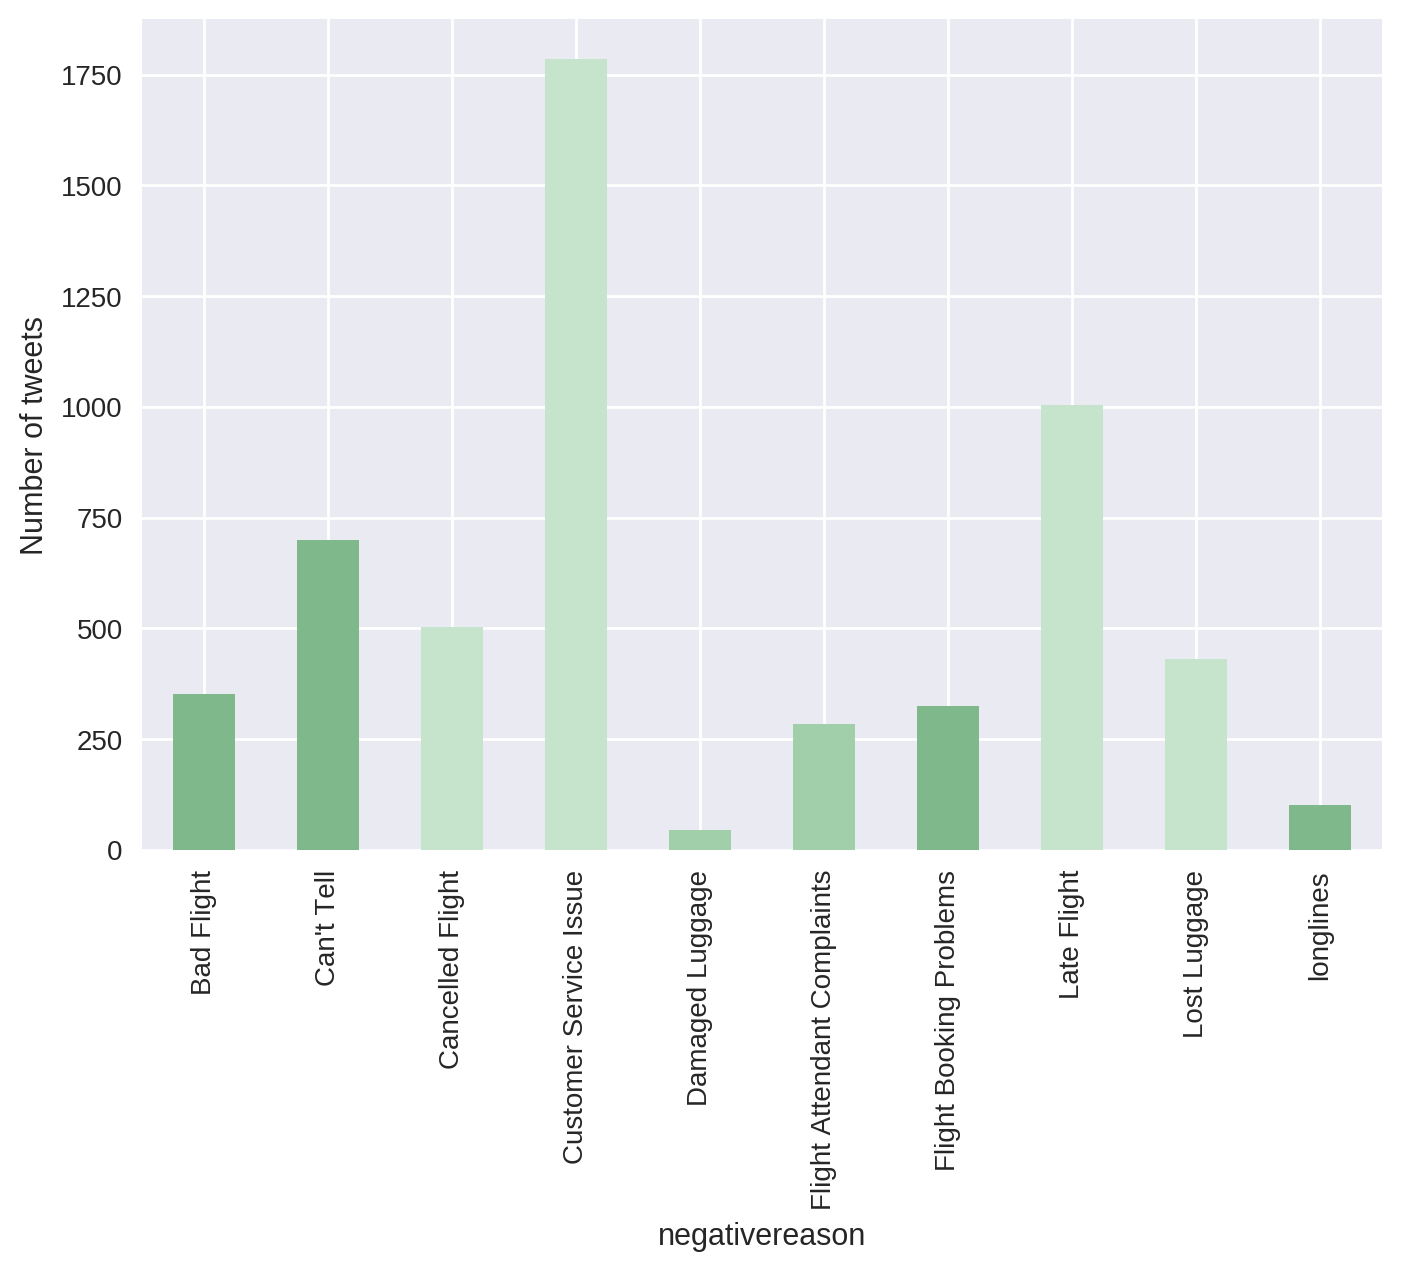

In [9]:
# Group items by reason now
reasons = df.groupby('negativereason').size()

# Calculate, for each group, the mean confidence
means = df.groupby('negativereason')['negativereason_confidence'].mean()

# Create a color palette and assign a color for each reason, 
# based on its confidence
current_palette = sns.cubehelix_palette(10, start=2, rot=0, dark=0, light=.95, reverse=True)
colors = [current_palette[int(round(means[name]*10))] for name in means.index]

# Bar plot of number of tweets per reason and its confidence
# The darker, the more confident
ax = reasons.plot.bar(color=colors)
ax.set_xticklabels(reasons.index, rotation='vertical')
ax.set_ylabel('Number of tweets')
plt.show()

As said, `tweet_created` provides the date on which it was sent.

We can reorder by dates and plot timelines based on days.

In [10]:
# Force the index to be the creation date
df_by_date = df.set_index('tweet_created')

### Tweets per day, by sentiment type

/home/guillem/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


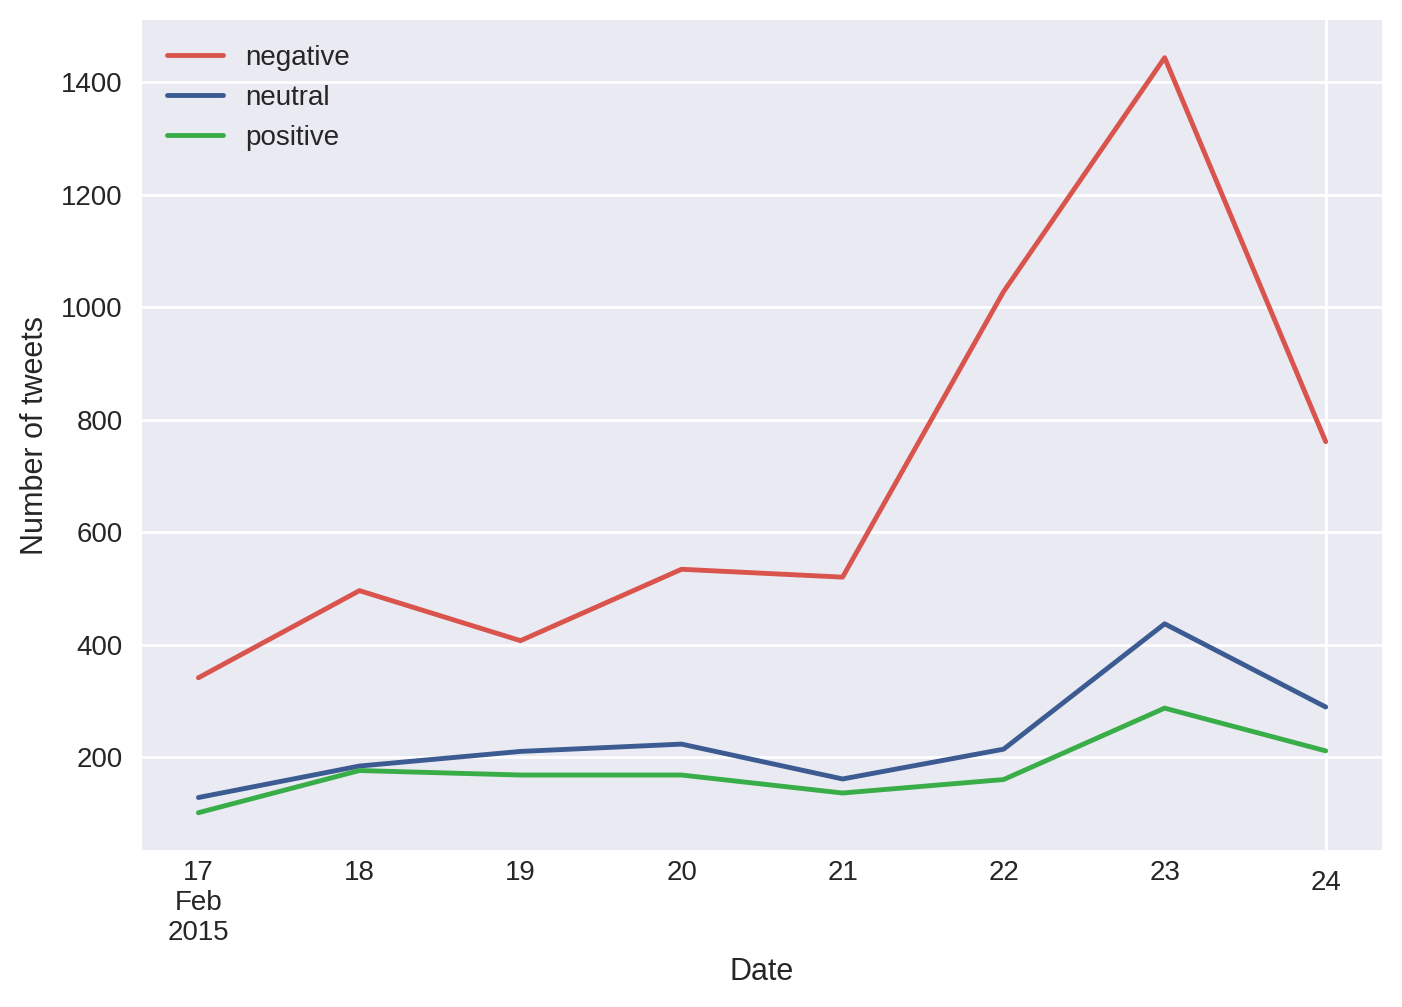

In [11]:
# Select only airline_sentiment
df_date_sent = df_by_date[['airline_sentiment']]

# Create a one-hot encoding. It converts a single column with a
# categorical value (like positive, neutral or negative) to $n$
# (3 in the example above) with 0's except for the column of
# the same category
#  sentiment              positive | neutral | negative
# -----------  ------->  -------------------------------
#  'neutral'                  0    |    1    |    0
#  'positive'                 1    |    0    |    0
#  'negative'                 0    |    0    |    1
sent_onehot = pd.get_dummies(df_date_sent['airline_sentiment'])

# Replace the categorial column with the one-hot encoding
df_date_sent = pd.concat((df_date_sent, sent_onehot)).drop('airline_sentiment', axis=1)

# Group by days and perform the sum per column, that is,
# accumulate on each sentiment-colunm the number of tweets
sums = df_date_sent.groupby(pd.TimeGrouper('D')).sum()

# Lines plot
ax = sums.plot(color=[sns.xkcd_rgb["pale red"], 
                      sns.xkcd_rgb["denim blue"], 
                      sns.xkcd_rgb["medium green"]])
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

### Wait what...? Sept 23rd

Let's see in more details what happended, with our data we can:

* See the reason for negative tweets
* Investigate which airline it was

Let's start by checking all reasons

/home/guillem/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # This is added back by InteractiveShellApp.init_path()


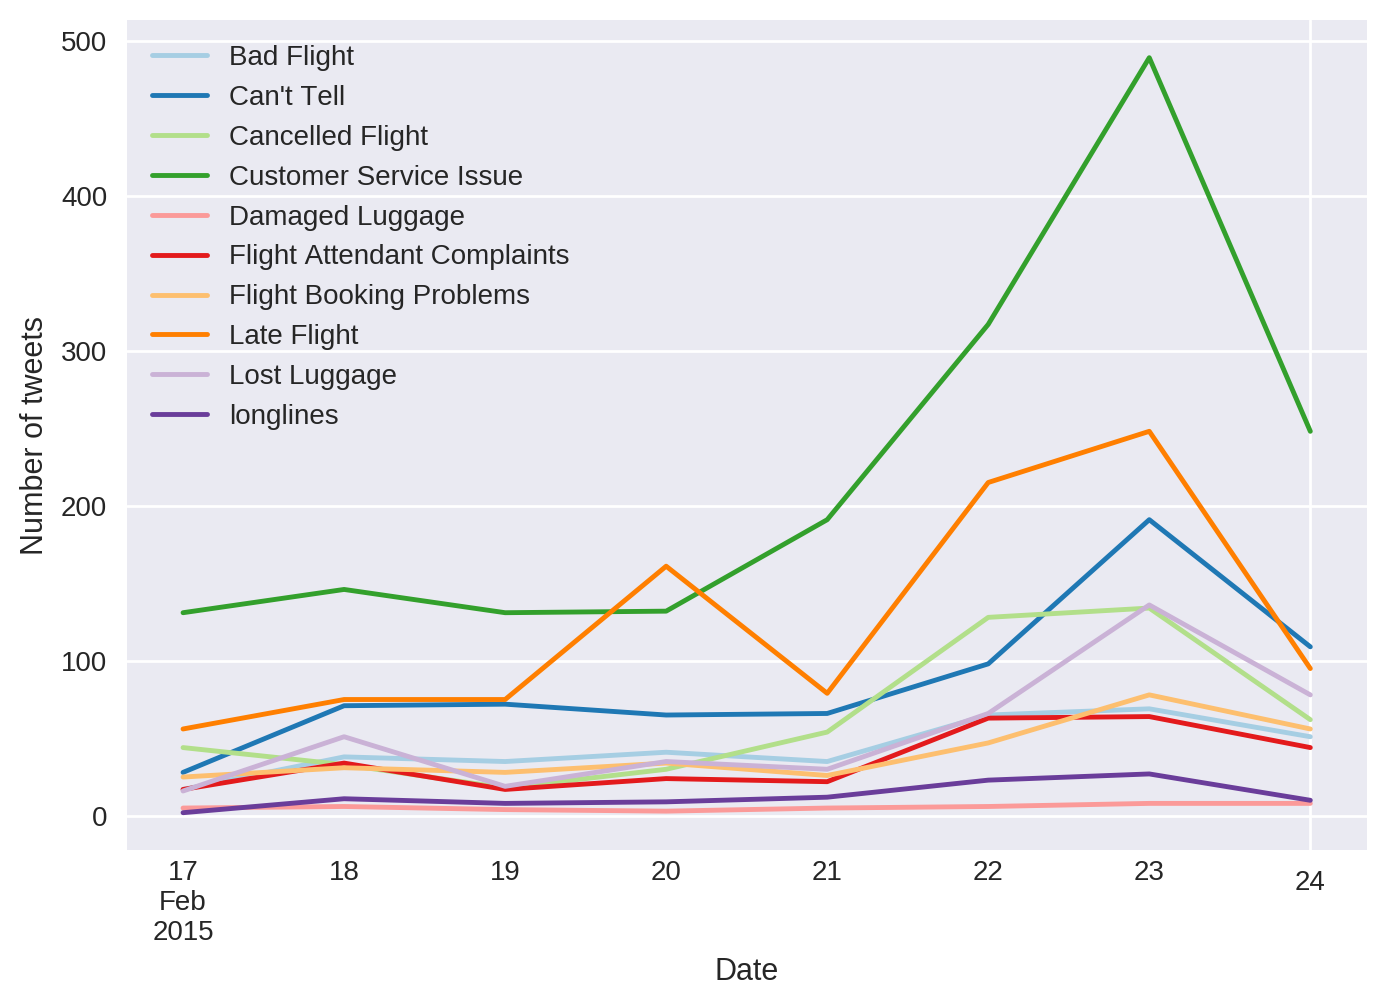

In [12]:
# Keep only reasons and sentiments
df_reasons = df_by_date[['negativereason', 'airline_sentiment']]
# Filter the dataset by keeping only negative tweets
df_reasons = df_reasons[df_reasons['airline_sentiment'] == 'negative']
# One-hot encoding of reasons
reason_onehot = pd.get_dummies(df_reasons['negativereason'])
# Replace categorical reasons for the one-hot encoding
df_reasons = pd.concat((df_reasons, reason_onehot)).drop(['negativereason', 'airline_sentiment'], axis=1)

# Group by dates and sum by reasons
sums = df_reasons.groupby(pd.TimeGrouper('D')).sum()

# Plot resulting sums
ax = sums.plot(color=sns.color_palette("Paired", n_colors=sums.shape[1]))
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

Clearly the main issue was with customer support, maybe unanswered tweets? support at the airports?

Let's dig further into the data by finding the culprit airline

/home/guillem/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # Remove the CWD from sys.path while we load stuff.


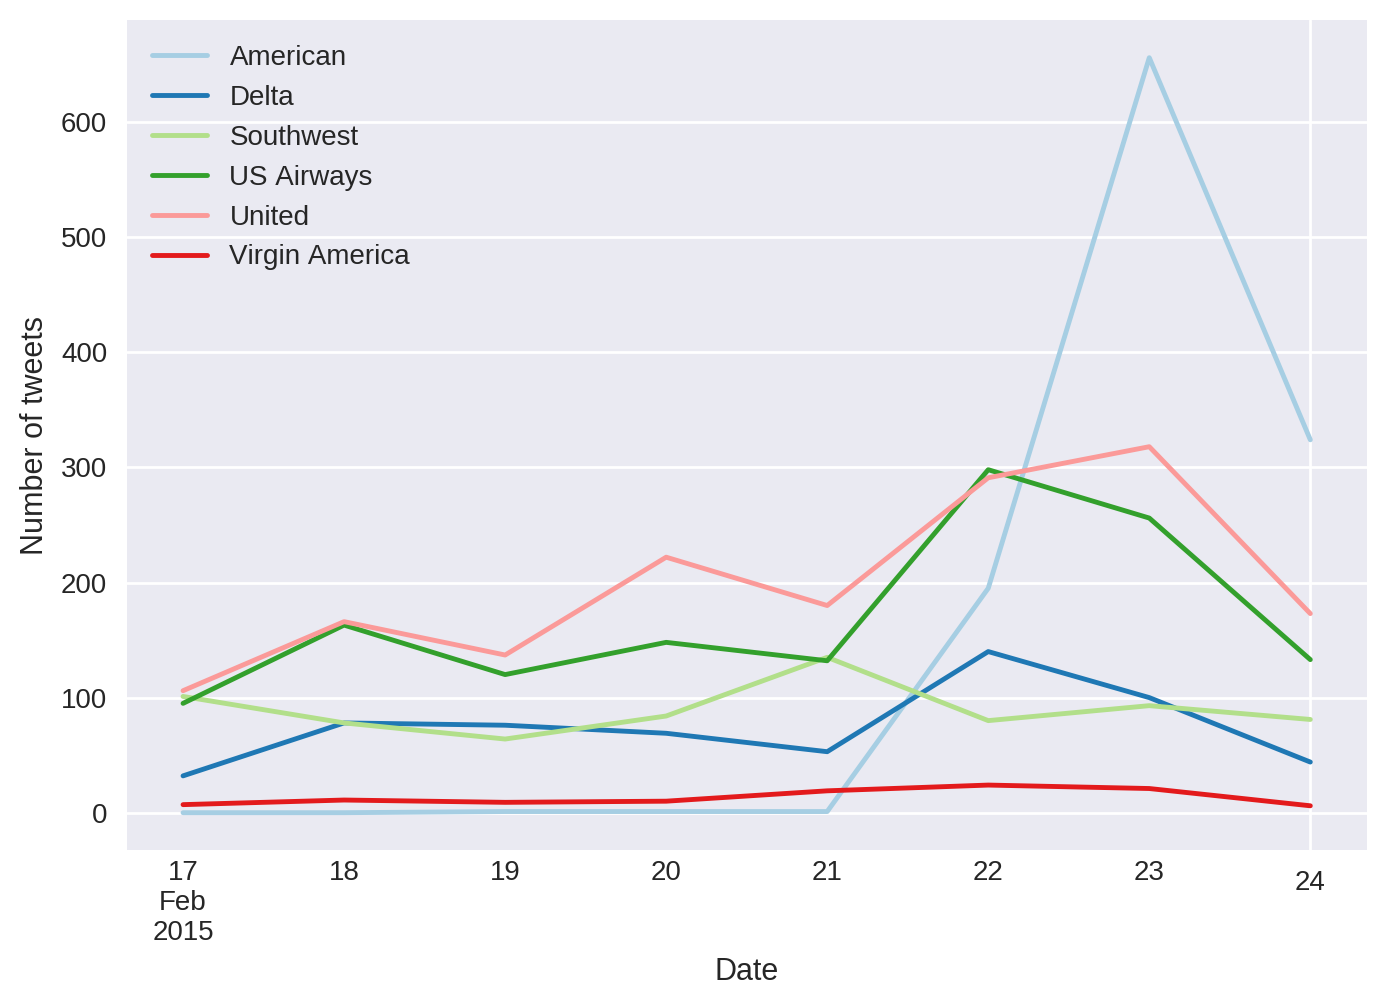

In [13]:
# Keep airlines and sentiments
df_airline = df_by_date[['airline', 'airline_sentiment']]
# Filter only negatives
df_airline = df_airline[df_airline['airline_sentiment'] == 'negative']
# One-hot encoding airlines
airline_onehot = pd.get_dummies(df_airline['airline'])
df_airline = pd.concat((df_airline, airline_onehot)).drop(['airline', 'airline_sentiment'], axis=1)

# Group by days, sum by airlines
sums = df_airline.groupby(pd.TimeGrouper('D')).sum()
# Plot
ax = sums.plot(color=sns.color_palette("Paired", n_colors=sums.shape[1]))
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

### American Airlines

It is clear American Airlines is the one causing the spike. A few things to notice:

* Previous to the 22nd there was no data for American
* There is an spike from the 22nd to the 23rd, in spite of the previous lack of data

Let's see only American Airlines related data

/home/guillem/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  # Remove the CWD from sys.path while we load stuff.


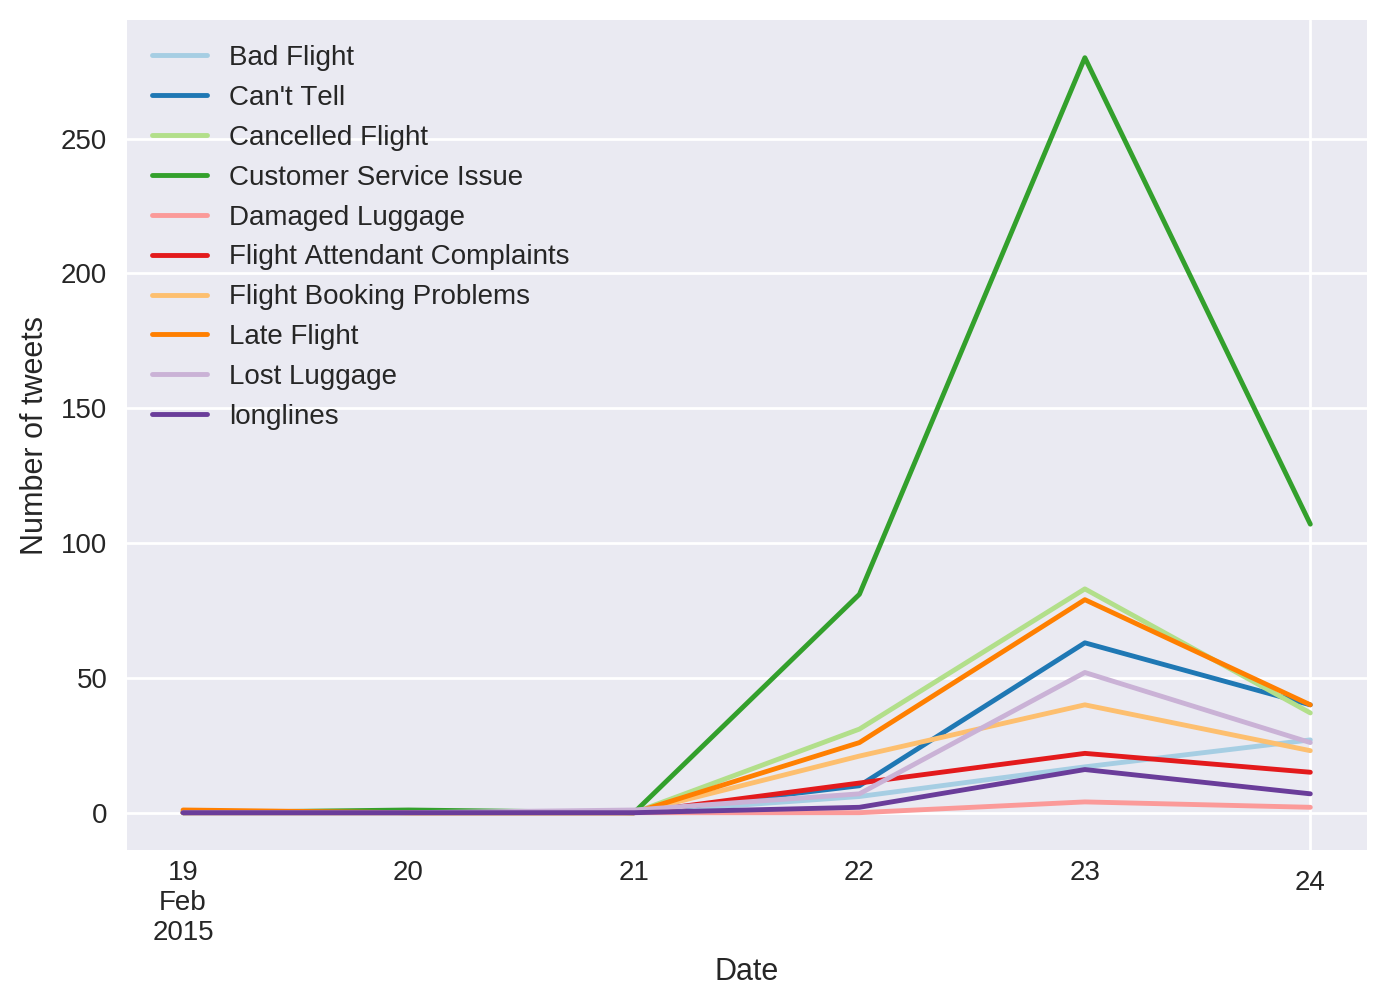

In [14]:
# Keep only relevant columns
df_american = df_by_date[['negativereason', 'airline', 'airline_sentiment']]
# Filter by American and negative only
df_american = df_american[(df_american['airline'] == 'American') & (df_american['airline_sentiment'] == 'negative')]
# One-hot enconding reasons
am_reasons_onehot = pd.get_dummies(df_american['negativereason'])
df_american = pd.concat((df_american, am_reasons_onehot)).drop(['negativereason', 'airline', 'airline_sentiment'], axis=1)

# Group by dates and sum by reasons
sums = df_american.groupby(pd.TimeGrouper('D')).sum()
ax = sums.plot(color=sns.color_palette("Paired", n_colors=sums.shape[1]))
ax.set_ylabel('Number of tweets')
ax.set_xlabel('Date')

## American Airlines, Sept. 23rd, customer service

Let's see a few more details of the tweets related to American Airlines for the 23rd of September and customer service issues

In [15]:
# Keep only tweets from the 23rd
sept_23 = df_by_date[df_by_date.index.day == 23]
# Keep only American Airlines from the ones before
american = sept_23[sept_23['airline'] == 'American']
# Keep only negatives from the ones before
negative = american[american['airline_sentiment'] == 'negative']
# Finally, keep only customer service issues
customer = negative[negative['negativereason'] == 'Customer Service Issue']

### Tweets visualization

In [16]:
try:
    from wordcloud import WordCloud, STOPWORDS
except:
    print('For the next cells you need WordCloud (pip install wordcloud)', file=sys.stderr)
    if input('Do you want me to do it for you? y/n') == 'y':
        !pip install wordcloud
        
    from wordcloud import WordCloud, STOPWORDS

### Visualizations

`WordCloud`s plot words in an image, using its frequency as font-size

(-0.5, 599.5, 299.5, -0.5)

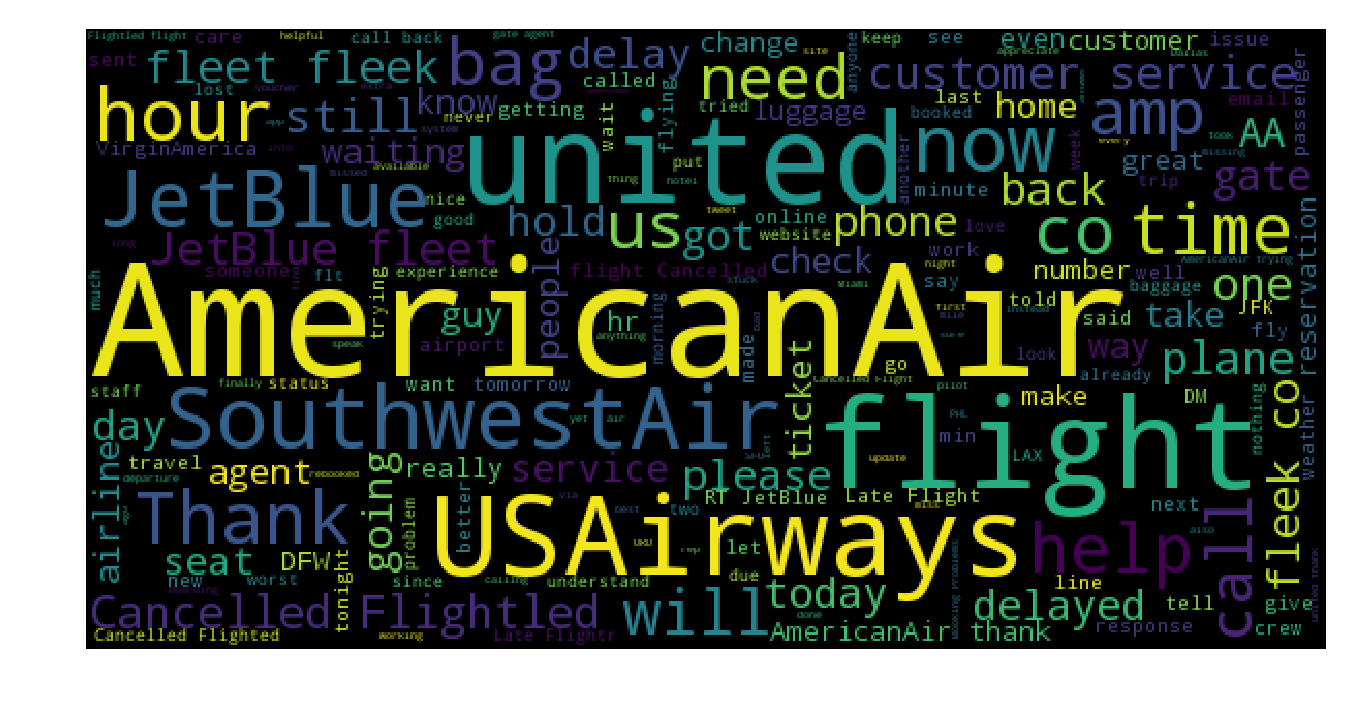

In [17]:
wc = {'width': 600, 'height': 300, 'random_state': 0}
wordcloud = WordCloud(**wc).generate(''.join(sept_23['text']))

plt.imshow(wordcloud)
plt.axis("off")

### Visualize American Airlines

To do so, filter some words that might not be relevant at all. For example, we don't need the word `AmericanAir` as of course we already know we are visualizing that.

(-0.5, 599.5, 299.5, -0.5)

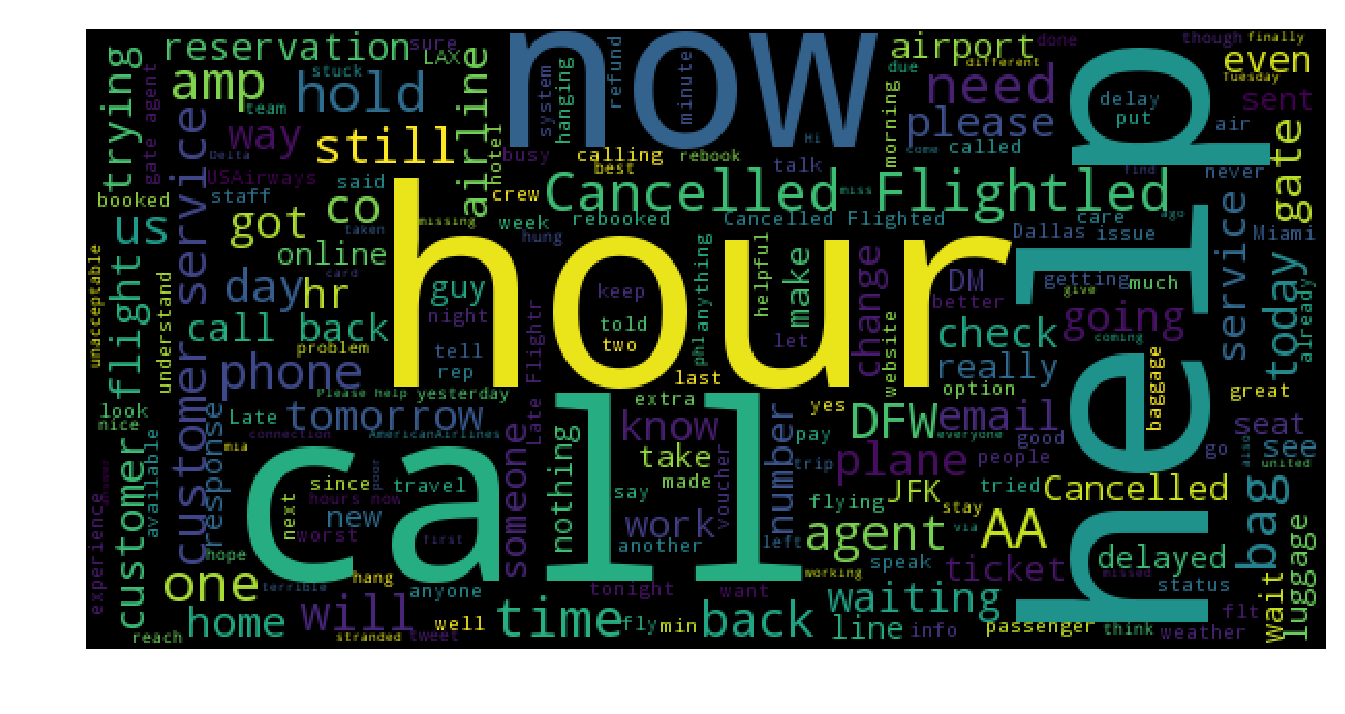

In [18]:
ignore = set(('AmericanAir', 'flight', 'thank', 'thanks'))
fwc = {'stopwords': STOPWORDS | ignore, **wc}
wordcloud = WordCloud(**fwc).generate(''.join(american['text']))

plt.imshow(wordcloud)
plt.axis("off")

### Visualize American Airlines negative tweets

Use the previous parameters with some words filtered out

(-0.5, 599.5, 299.5, -0.5)

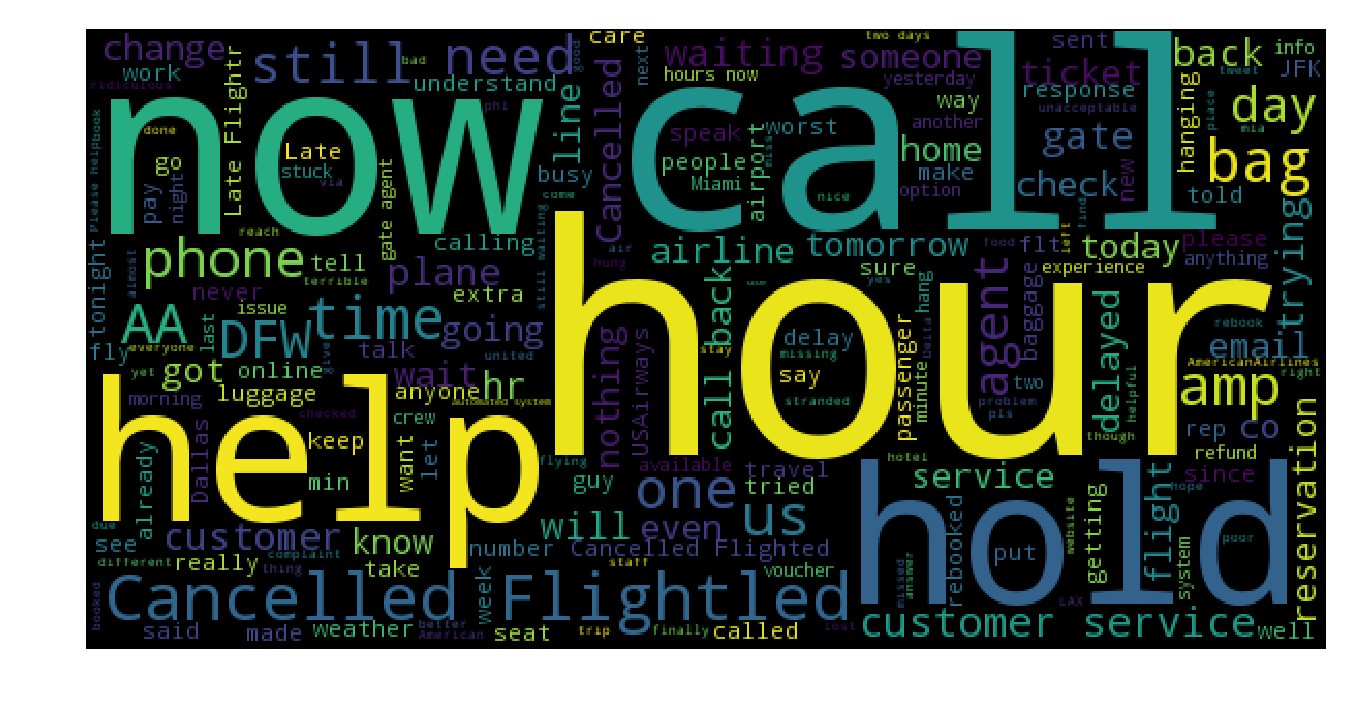

In [19]:
wordcloud = WordCloud(**fwc).generate(''.join(negative['text']))

plt.imshow(wordcloud)
plt.axis("off")

### Visualize American Airlines negative tweets, related with customer issues

Use the previous parameters with some words filtered out

(-0.5, 599.5, 299.5, -0.5)

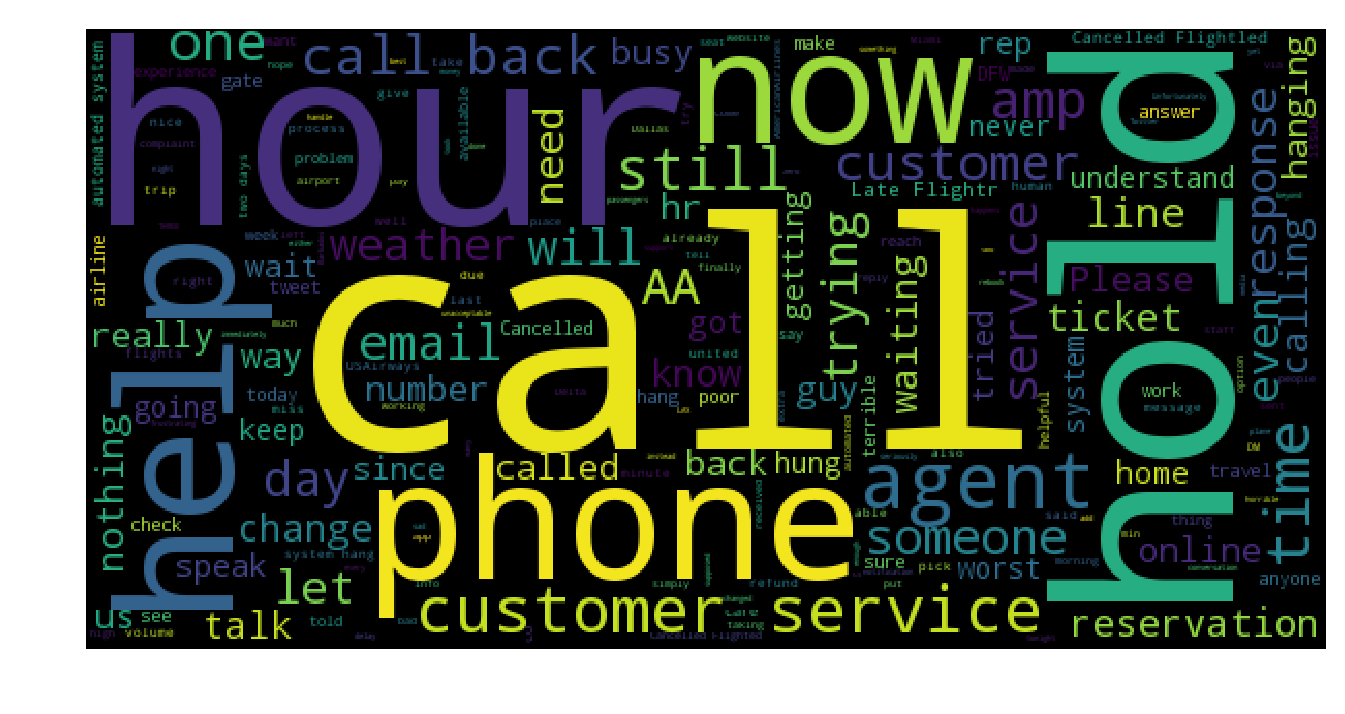

In [20]:
wordcloud = WordCloud(**fwc).generate(''.join(customer['text']))

plt.imshow(wordcloud)
plt.axis("off")

### A little bit of research shows that

In [21]:
from IPython.display import IFrame
IFrame("https://www.aeroinside.com/item/5362/american-b763-near-london-on-feb-23rd-2015-cracked-windshield", "100%", "500px")

# Proposed questions

To prepare for the following sessions, there are a few questions that might be worth to answer. This is for you, and it is highly recommended to do some research!

A) Try to find the most common words on each sentiment category

B) Are those words meaningful at all? Can you think of any way to filter them out?

C) Take a look at a technique known as bag of words. As we are dealing with text we need a numerical representation with which we can create models.

Think on how you could apply it with this particular problem and our 3 categories.